In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt


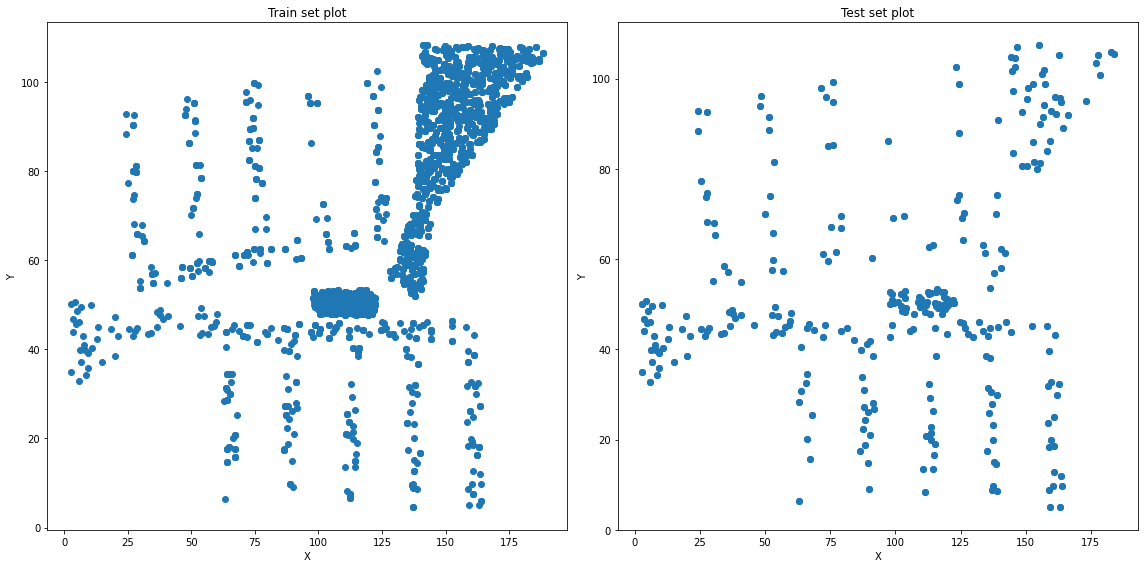

In [2]:
# load train data
data1 = np.load('FireEvac_train_set.npy')
x1 = data1[:, 0]
y1 = data1[:, 1]

# load test data
data2 = np.load('FireEvac_test_set.npy')
x2 = data2[:, 0]
y2 = data2[:, 1]

# create scatter plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

# first scatter plot
ax1.scatter(x1, y1)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_title('Train set plot')

# second scatter plot
ax2.scatter(x2, y2)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.set_title('Test set plot')

# adjust the distance
plt.tight_layout()

# show plot
plt.show()

In [3]:
# load the training and test data
train_data = np.load("FireEvac_train_set.npy")
test_data = np.load("FireEvac_test_set.npy")


# normalize the data to have zero mean and unit variance
train_mean = np.mean(train_data, axis=0)
train_std = np.std(train_data, axis=0)
train_data = (train_data - train_mean) / train_std
test_data = (test_data - train_mean) / train_std

# train_data_min = np.min(train_data, axis=0)
# train_data_max = np.max(train_data, axis=0)
#
# train_data_range = train_data_max - train_data_min
#
# train_data = 2 * (train_data - train_data_min) / train_data_range - 1
# test_data = 2 * (test_data - train_data_min) / train_data_range - 1


# convert data to PyTorch tensors
train_tensor = torch.Tensor(train_data)
test_tensor = torch.Tensor(test_data)

# parameter
batch_size = 128
train_dataset = TensorDataset(train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
latent_dim = 2


In [4]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(2, 32),
            nn.ReLU(),
            nn.Linear(32, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU()
        )

        # latent space
        self.fc_mean = nn.Linear(128, latent_dim)
        self.fc_logvar = nn.Linear(128, latent_dim)

        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2)
        )

    def encode(self, x):
        x = self.encoder(x)
        mean = self.fc_mean(x)
        logvar = self.fc_logvar(x)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z = mean + eps * std
        return z

    def decode(self, z):
        x = self.decoder(z)
        return x

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterize(mean, logvar)
        x_recon = self.decode(z)
        return x_recon, mean, logvar

model = VAE()

# loss function
def vae_loss(inputs, outputs, mean, logvar):
    reconstruction_loss = nn.MSELoss(reduction='mean')(inputs, outputs)
    kl_loss = -0.5 * torch.mean(1 + logvar - mean.pow(2) - logvar.exp())
    return reconstruction_loss + kl_loss

# optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# train
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for batch in train_dataloader:
        inputs = batch[0]
        optimizer.zero_grad()
        outputs, mean, logvar = model(inputs)
        loss = vae_loss(inputs, outputs, mean, logvar)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * len(inputs)

    train_loss /= len(train_dataset)
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}")

# evaluate the loss
model.eval()
with torch.no_grad():
    test_inputs = test_tensor
    test_outputs, _, _ = model(test_inputs)
    test_loss = vae_loss(test_inputs, test_outputs, mean, logvar)
    print("Test Loss:", test_loss.item())


Epoch 1/200, Train Loss: 1.0014
Epoch 2/200, Train Loss: 0.9101
Epoch 3/200, Train Loss: 0.7503
Epoch 4/200, Train Loss: 0.7347
Epoch 5/200, Train Loss: 0.7186
Epoch 6/200, Train Loss: 0.7275
Epoch 7/200, Train Loss: 0.7194
Epoch 8/200, Train Loss: 0.7158
Epoch 9/200, Train Loss: 0.7161
Epoch 10/200, Train Loss: 0.7036
Epoch 11/200, Train Loss: 0.6986
Epoch 12/200, Train Loss: 0.7008
Epoch 13/200, Train Loss: 0.7064
Epoch 14/200, Train Loss: 0.6920
Epoch 15/200, Train Loss: 0.6875
Epoch 16/200, Train Loss: 0.6878
Epoch 17/200, Train Loss: 0.6877
Epoch 18/200, Train Loss: 0.6949
Epoch 19/200, Train Loss: 0.6882
Epoch 20/200, Train Loss: 0.7097
Epoch 21/200, Train Loss: 0.6950
Epoch 22/200, Train Loss: 0.7117
Epoch 23/200, Train Loss: 0.6973
Epoch 24/200, Train Loss: 0.6895
Epoch 25/200, Train Loss: 0.6937
Epoch 26/200, Train Loss: 0.6925
Epoch 27/200, Train Loss: 0.6949
Epoch 28/200, Train Loss: 0.6917
Epoch 29/200, Train Loss: 0.6972
Epoch 30/200, Train Loss: 0.6932
Epoch 31/200, Train

In [5]:
# convert the test data and reconstructed data to numpy arrays
test_data_np = test_data
reconstructed_data_np = test_outputs.detach().numpy()


In [6]:
# print(test_data_np)
# print(reconstructed_data_np)
# print(generated_samples_np)

In [7]:
# scale the test data and reconstructed data back to the original range
test_data_np = test_data_np * train_std + train_mean
reconstructed_data_np = reconstructed_data_np * train_std + train_mean

# test_data_np = (test_data_np + 1) * test_data_range /2 + test_data_min
# reconstructed_data_np = (reconstructed_data_np + 1) * test_data_range /2 + test_data_min
# # generated_samples_np = (reconstructed_data_np + 1) * train_data_range /2 + train_data_min

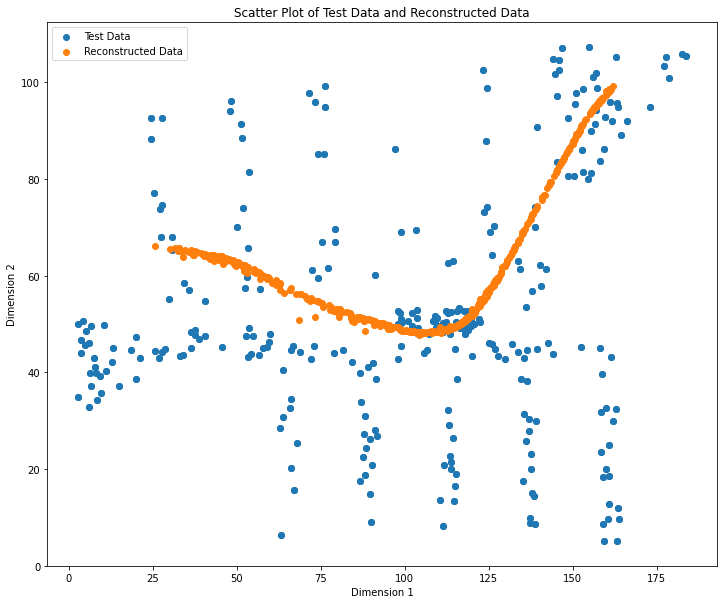

In [8]:
# visualize the reconstructed data in a scatter plot
plt.figure(figsize=(12, 10))
plt.scatter(test_data_np[:, 0], test_data_np[:, 1], label='Test Data')
plt.scatter(reconstructed_data_np[:, 0], reconstructed_data_np[:, 1], label='Reconstructed Data')
plt.title('Scatter Plot of Test Data and Reconstructed Data')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()
plt.show()


In [9]:
# generate new samples from the learned distribution p(x)
num_samples = 1000
latent_samples = torch.randn(num_samples, latent_dim)
generated_samples = model.decode(latent_samples)

# data processing
generated_samples_np = generated_samples.detach().numpy()
generated_samples_np = generated_samples_np * train_std + train_mean

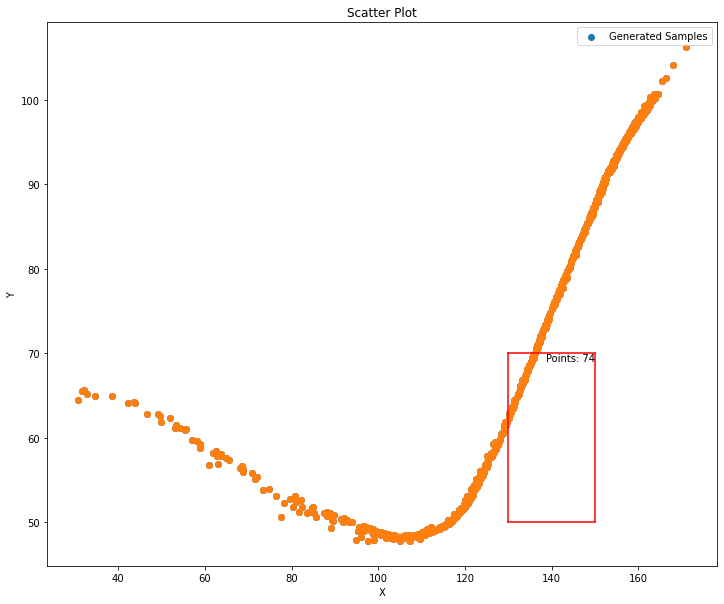

In [10]:
# visualize the generated samples in a scatter plot
plt.figure(figsize=(12, 10))
plt.scatter(generated_samples_np[:, 0], generated_samples_np[:, 1], label='Generated Samples')
plt.title('Scatter Plot of Generated Samples')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

x = generated_samples_np[:, 0]
y = generated_samples_np[:, 1]

plt.scatter(x, y)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Scatter Plot')

# define boundaries
x_min = 130
x_max = 150
y_min = 50
y_max = 70

# filter the given area
filtered_data = generated_samples_np[(x >= x_min) & (x <= x_max) & (y >= y_min) & (y <= y_max)]

# count the points
num_points = len(filtered_data)

# mark the area
plt.plot([x_min, x_min], [y_min, y_max], color='r', linestyle='-')
plt.plot([x_max, x_max], [y_min, y_max], color='r', linestyle='-')
plt.plot([x_min, x_max], [y_min, y_min], color='r', linestyle='-')
plt.plot([x_min, x_max], [y_max, y_max], color='r', linestyle='-')

# mark the result of counting
plt.text(x_max, y_max, f'Points: {num_points}', ha='right', va='top')
plt.show()